# Case Study: Predicting the price of diamonds

## Importing the required packages

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Add a Dartmouth-y color theme
import matplotlib as mpl
dartmouth_colors = ["#00693E", "#12312B", "#C3DD88", "#6EAA8D", "#797979", "#EBF3EF"]
mpl.rcParams.update({
                        'figure.facecolor': "#EBF3EF",
                        'figure.figsize': [7.50, 3.50],
                        'axes.prop_cycle': mpl.cycler(color=dartmouth_colors),
                        'axes.facecolor': "#FFFFFF",
                        'axes.labelcolor': '#12312B',
                        'text.color': '#12312B'
                    })

%config InlineBackend.figure_formats = ['retina']


## Loading the dataset

In [16]:
diamonds = sns.load_dataset('diamonds')
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Encoding the categorical variables

In [17]:
# Use numeric values for ordinal categorical features
diamonds.cut = diamonds.cut.map({
    'Fair': 1,
    'Good': 2,
    'Very Good': 3,
    'Premium': 4,
    'Ideal': 5
    })
diamonds.color = diamonds.color.map({
    'D': 7,
    'E': 6,
    'F': 5,
    'G': 4,
    'H': 3,
    'I': 2,
    'J': 1
    })
diamonds.clarity = diamonds.clarity.map({
    'I1': 1,
    'SI2': 2,
    'SI1': 3,
    'VS2': 4,
    'VS1': 5,
    'VVS2': 6,
    'VVS1': 7,
    'IF': 8
})
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,5,6,2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,4,6,3,59.8,61.0,326,3.89,3.84,2.31
2,0.23,2,6,5,56.9,65.0,327,4.05,4.07,2.31
3,0.29,4,2,4,62.4,58.0,334,4.20,4.23,2.63
4,0.31,2,1,2,63.3,58.0,335,4.34,4.35,2.75


## Splitting the data into a training and test set

In [18]:
diamonds_test = diamonds.sample(frac=.1)
diamonds = diamonds.drop(diamonds_test.index)
print(f"We use {diamonds.shape[0]} observations for training and {diamonds_test.shape[0]} observations for testing.")

We use 48546 observations for training and 5394 observations for testing.


## Remove outliers

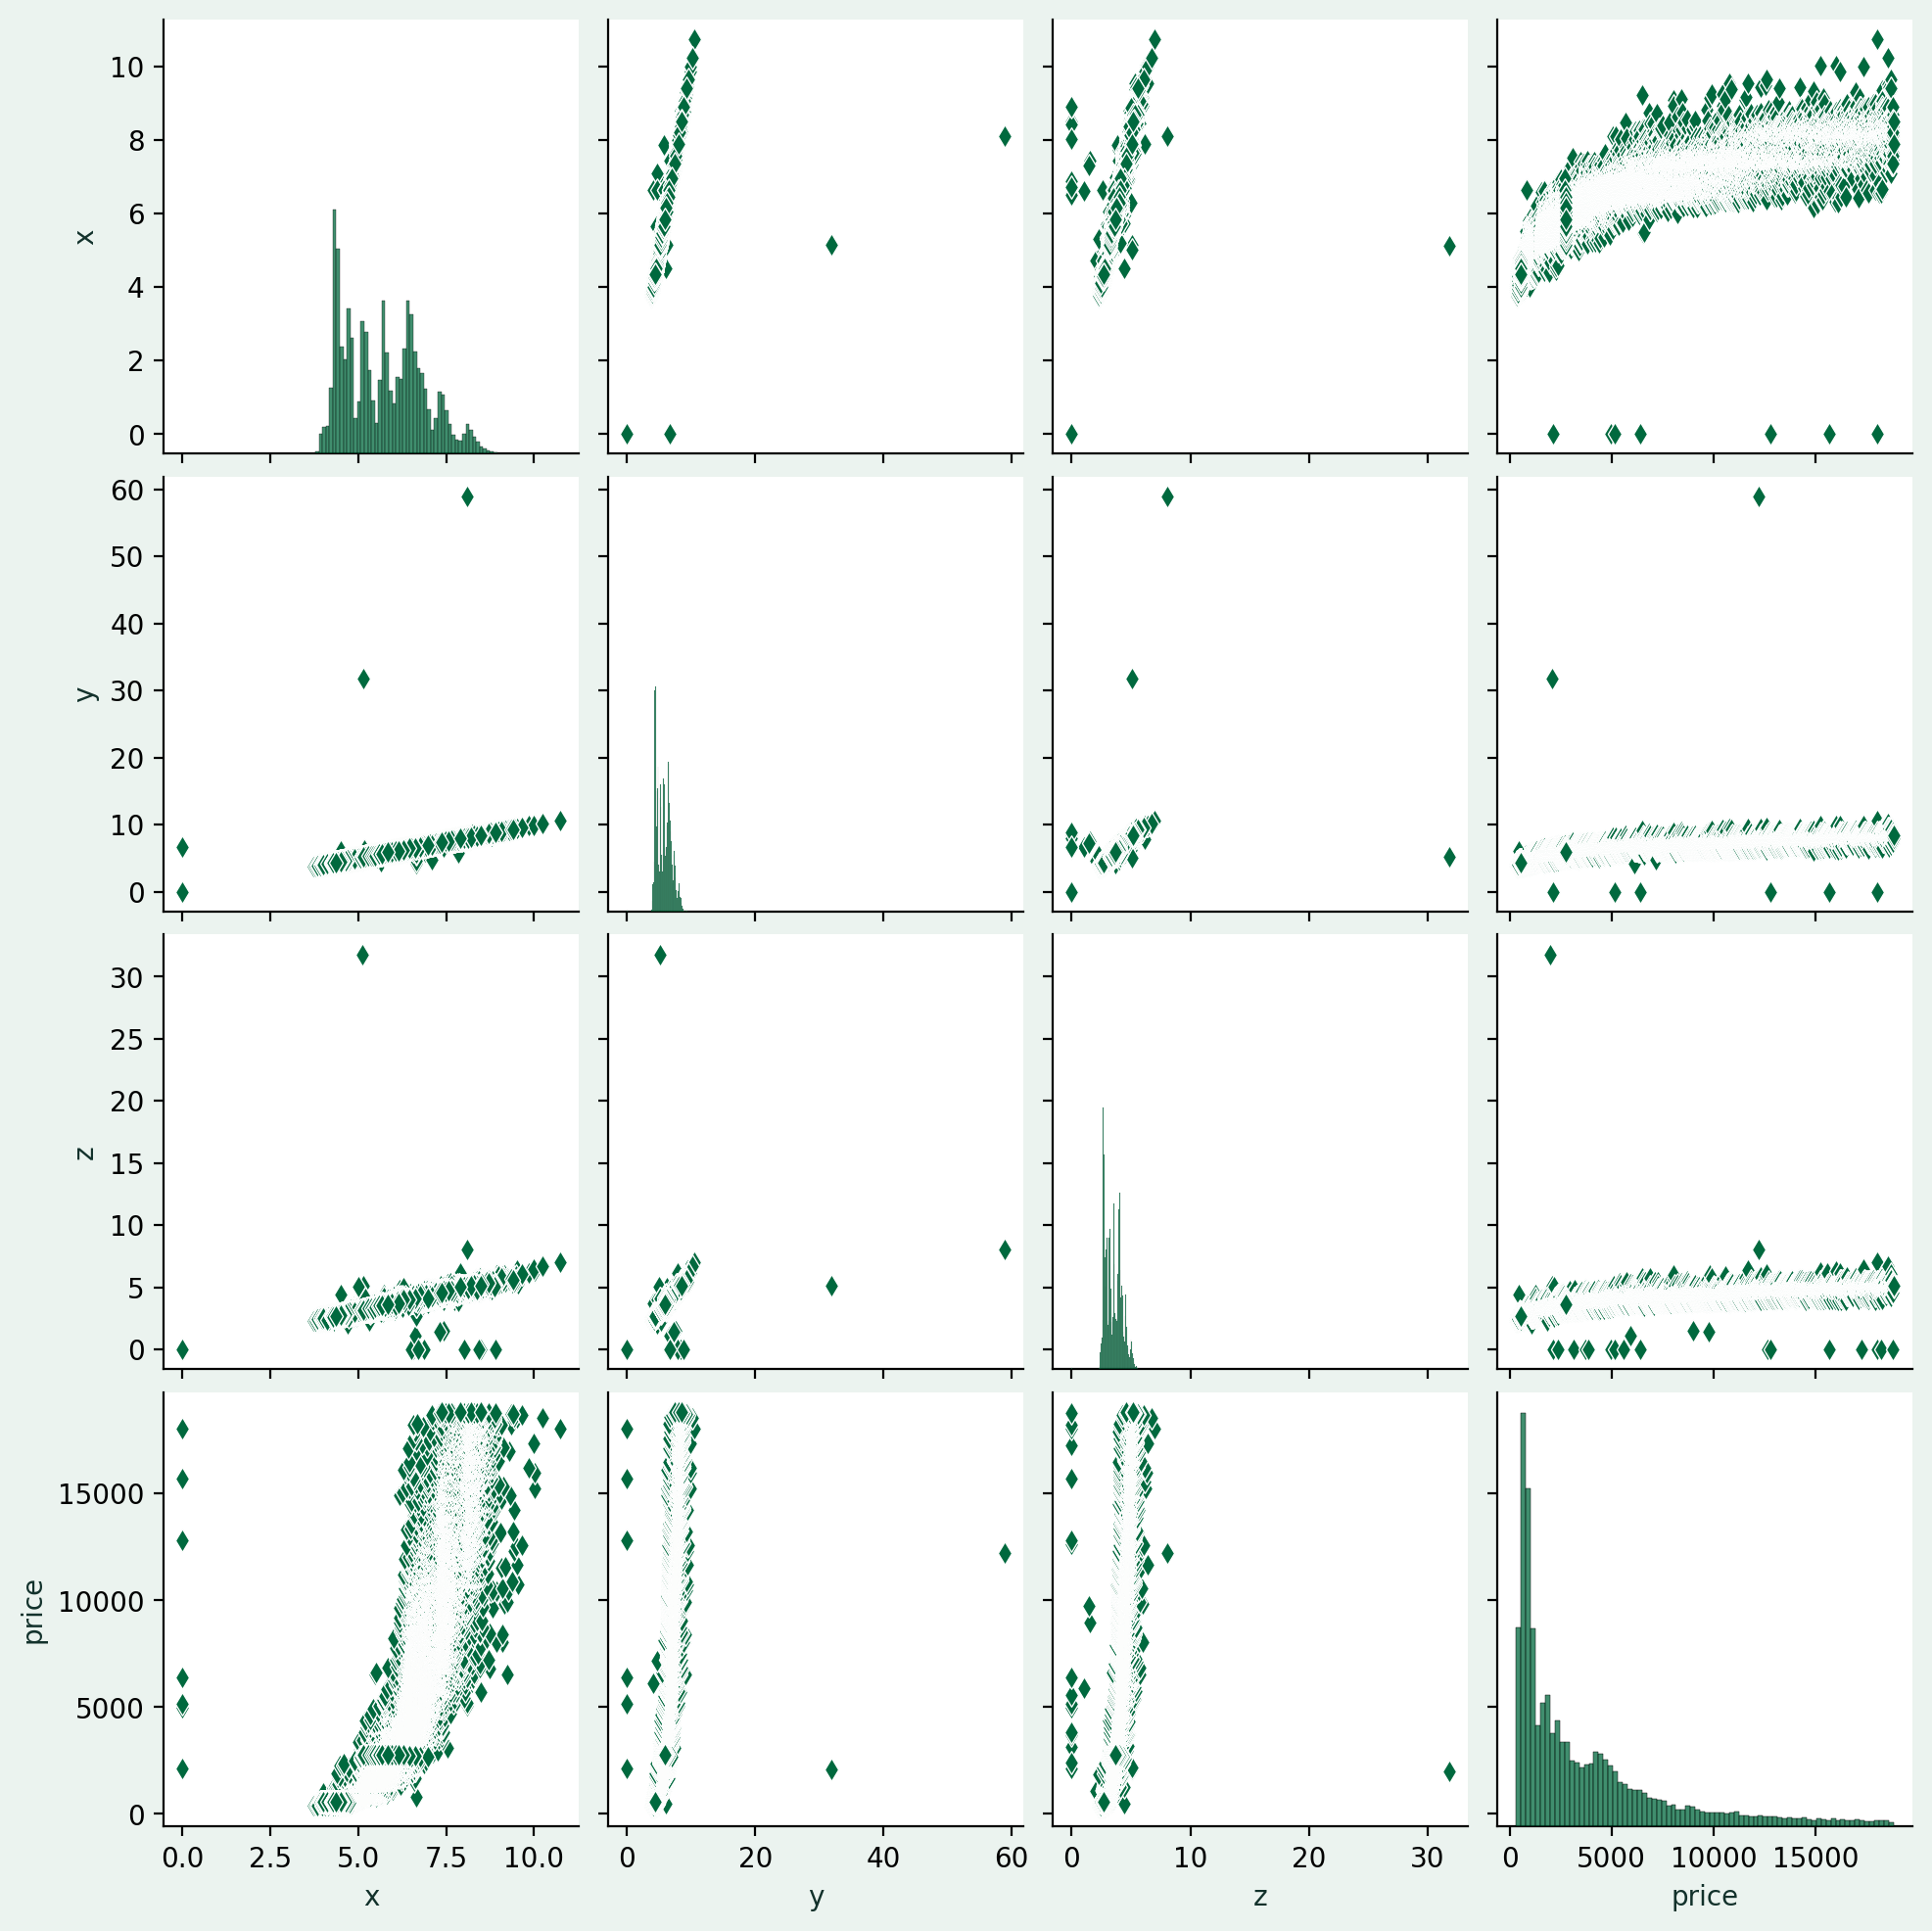

In [19]:
sns.pairplot(diamonds[['x', 'y', 'z', 'price']], plot_kws={'marker': 'd'})

Remove everything more than three standard deviations away from the mean:

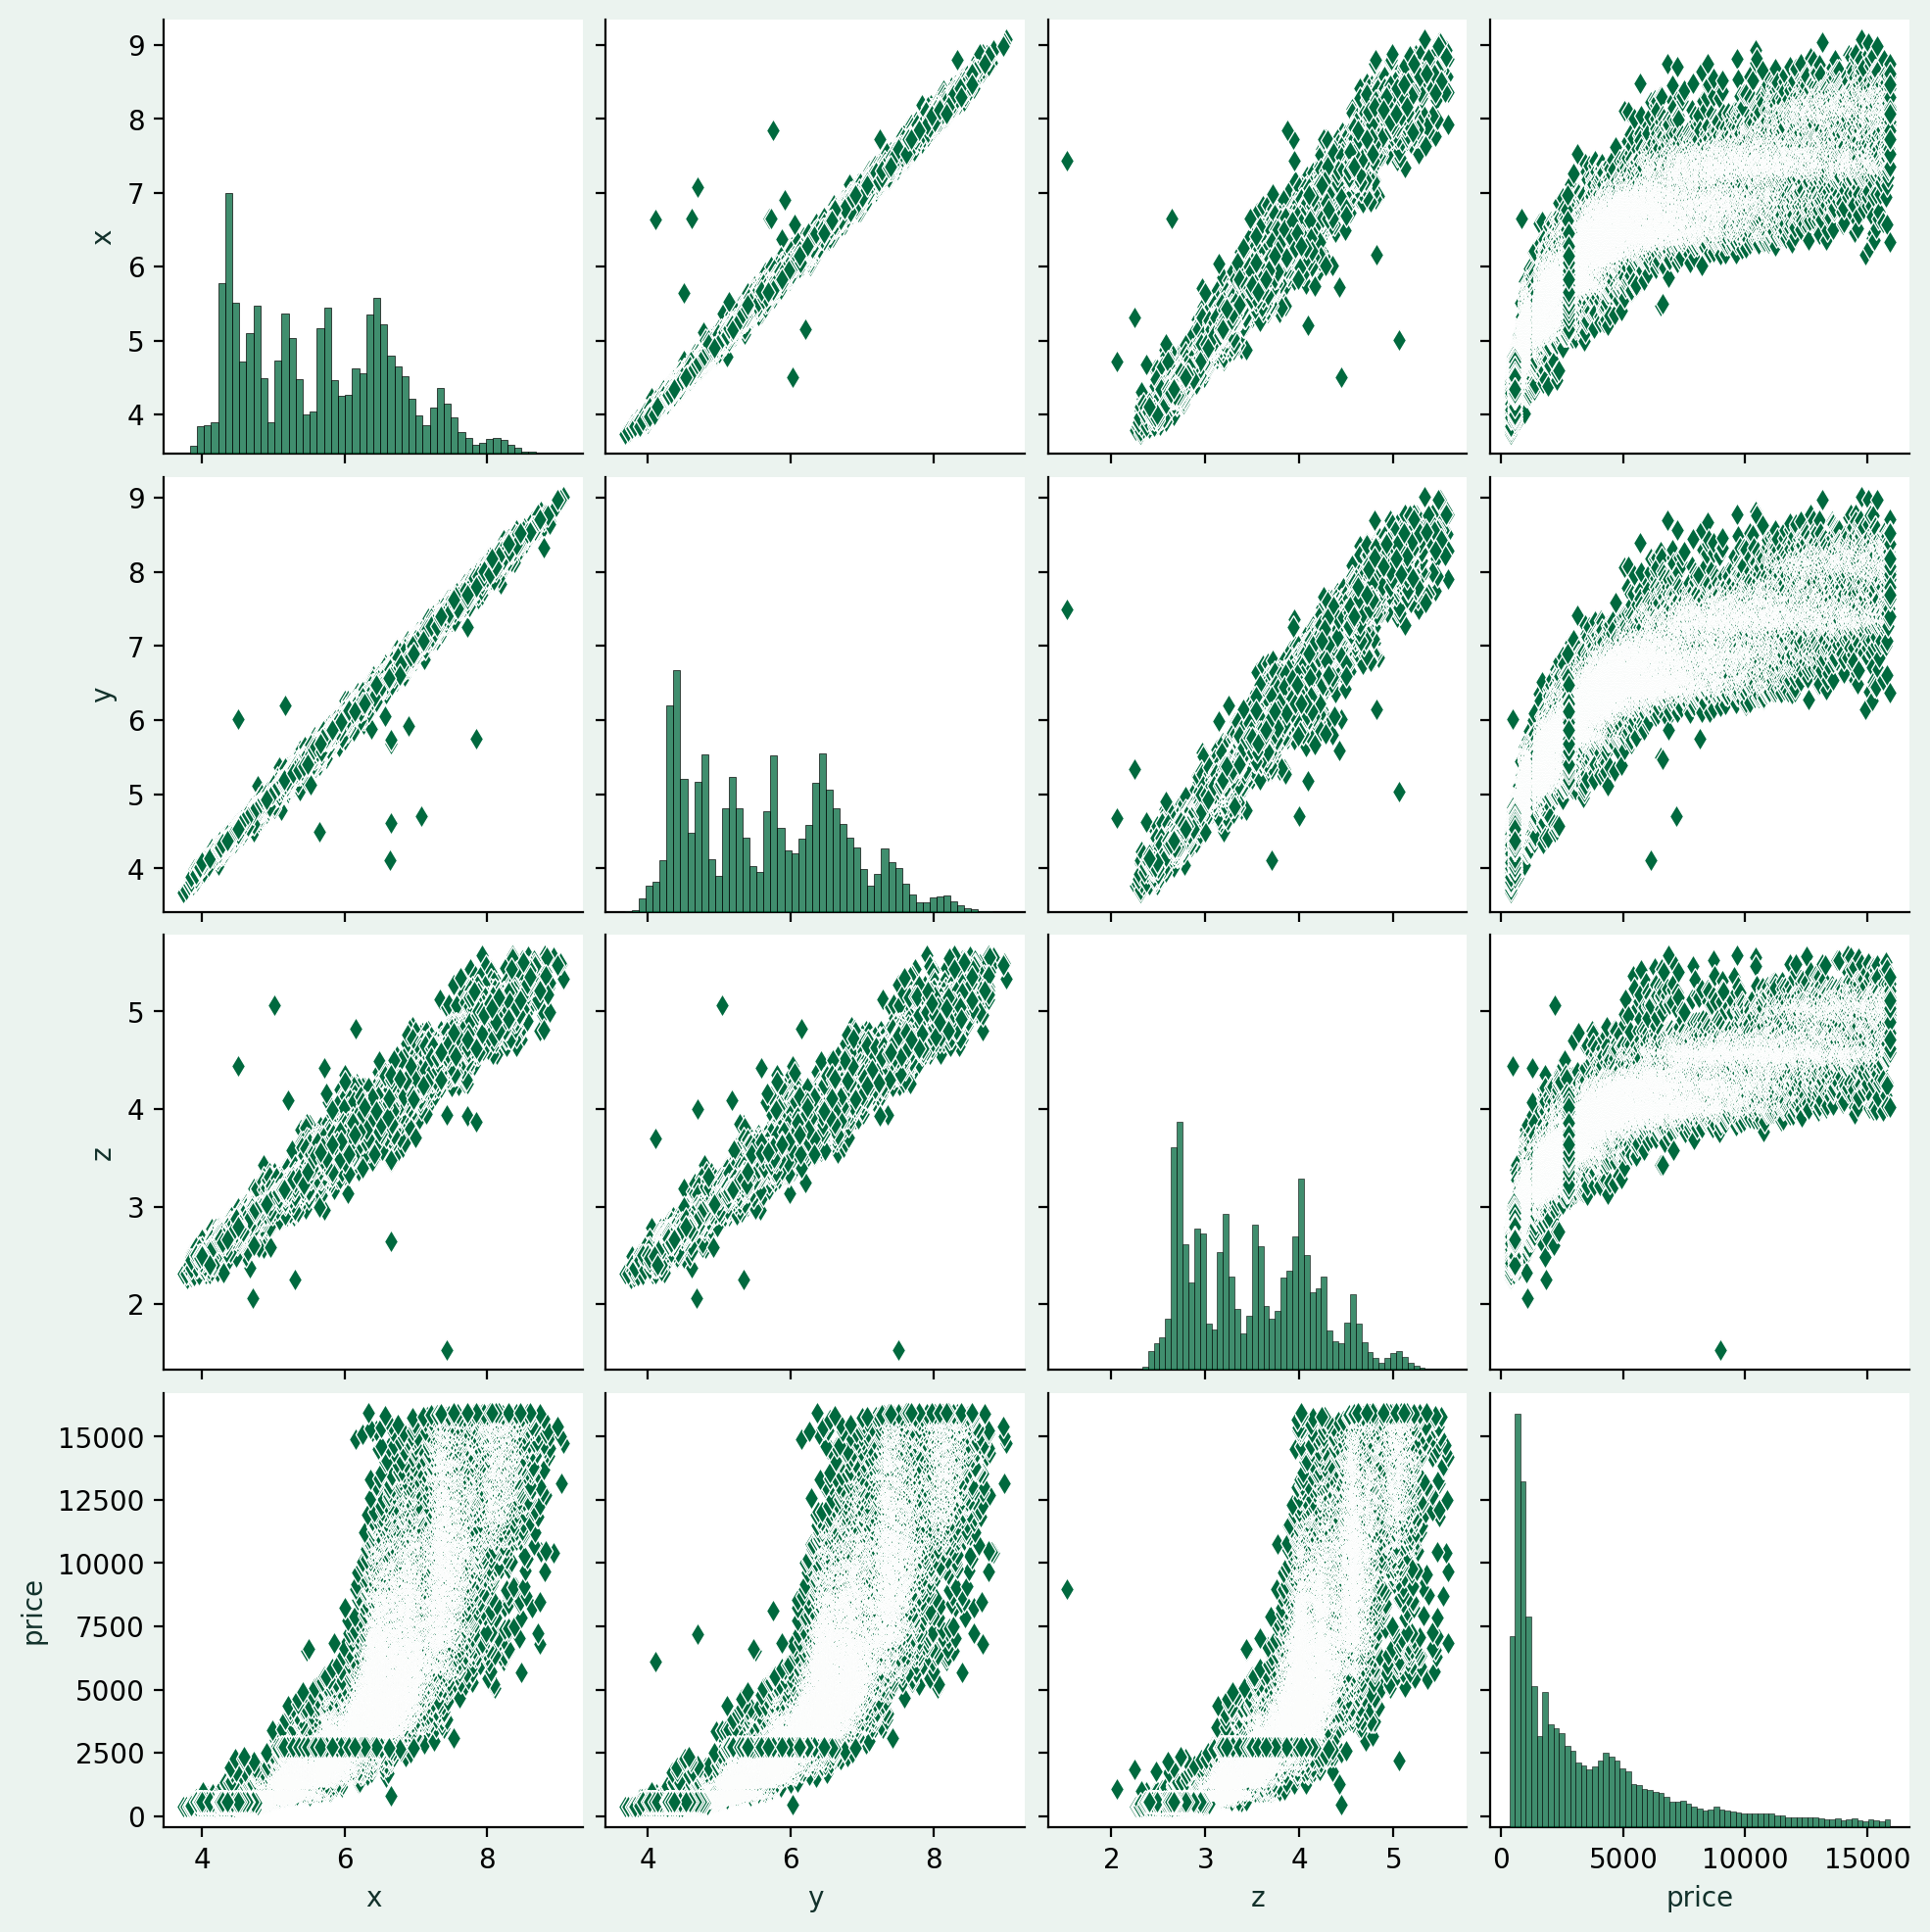

In [20]:
is_typical_x = abs((diamonds.x - diamonds.x.mean())) < 3 * diamonds.x.std()
is_typical_y = abs((diamonds.y - diamonds.y.mean())) < 3 * diamonds.y.std()
is_typical_z = abs((diamonds.z - diamonds.z.mean())) < 3 * diamonds.z.std()
is_typical_price = abs((diamonds.price - diamonds.price.mean())) < 3 * diamonds.price.std()

diamonds = diamonds[is_typical_x & is_typical_y & is_typical_z & is_typical_price]
sns.pairplot(diamonds[['x', 'y', 'z', 'price']], plot_kws={'marker': 'd'})


The relationship between `x`, `y`, `z` and `price` appears to be not linear, but exponential. We should therefore log-transform the target variable:

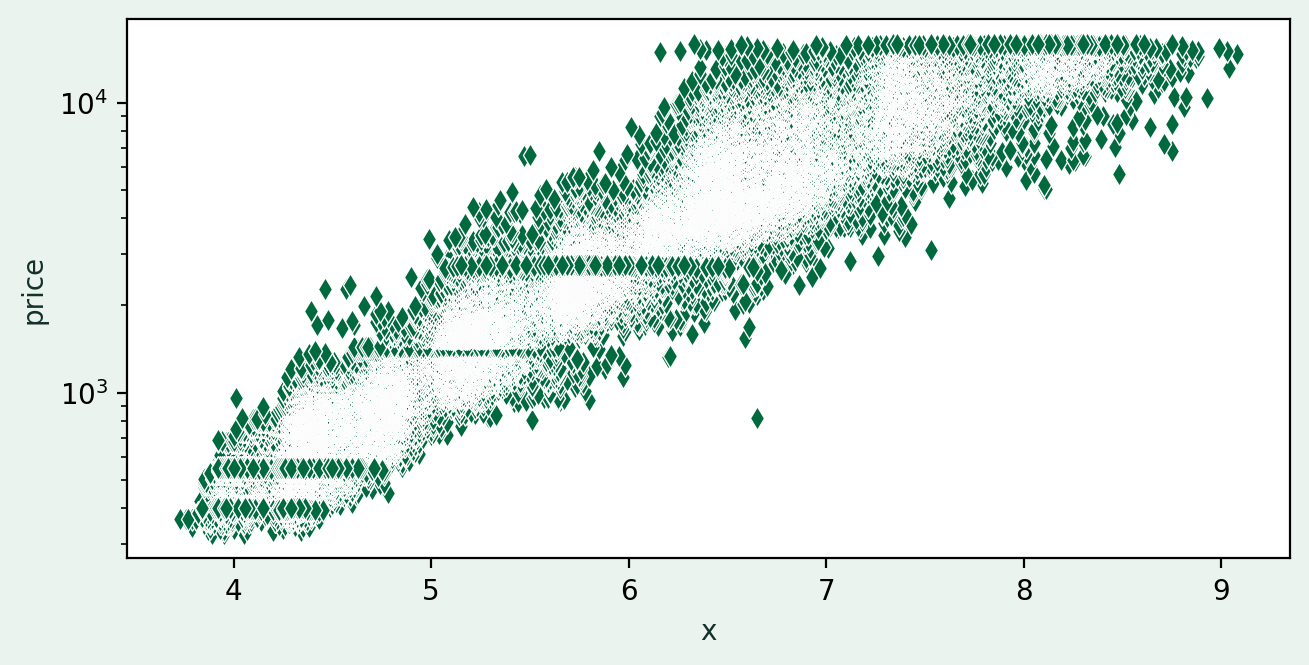

In [21]:
sns.scatterplot(diamonds, x='x', y='price', marker='d')
plt.yscale('log')

## Train the model

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

features = ['carat', 'x', 'y', 'z', 'table', 'depth', 'cut', 'color', 'clarity']

X = diamonds[features]
X_test = diamonds_test[features]

y = diamonds['price']
y_test = diamonds_test['price']

model = LinearRegression()

# Log-transform the target variable
model.fit(X, np.log(y))


LinearRegression()

## Interpret the model

In [23]:
for coef, feature in zip(model.coef_, model.feature_names_in_):
    print(f"Weight of {feature}: {coef:.2f}")

print('-'*40)
print("Effect of increasing the feature's value by 1 on predicted price:")
for coef, feature in zip(model.coef_, features):
    print(f"{feature:>20} + 1 ->  {(np.exp(coef) - 1) * 100:+.2f} %")

Weight of carat: -1.13
Weight of x: 0.67
Weight of y: 0.41
Weight of z: 0.58
Weight of table: 0.01
Weight of depth: 0.03
Weight of cut: 0.03
Weight of color: 0.08
Weight of clarity: 0.12
----------------------------------------
Effect of increasing the feature's value by 1 on predicted price:
               carat + 1 ->  -67.73 %
                   x + 1 ->  +96.35 %
                   y + 1 ->  +50.39 %
                   z + 1 ->  +78.43 %
               table + 1 ->  +0.98 %
               depth + 1 ->  +2.96 %
                 cut + 1 ->  +2.84 %
               color + 1 ->  +8.02 %
             clarity + 1 ->  +12.74 %


## Evaluate the model's performance

In [24]:
# Transform predictions back to original scale using exponential (inverse of log)
y_predict = np.exp(model.predict(X_test))

mean_absolute_error(y_test, y_predict)

459.110510308391

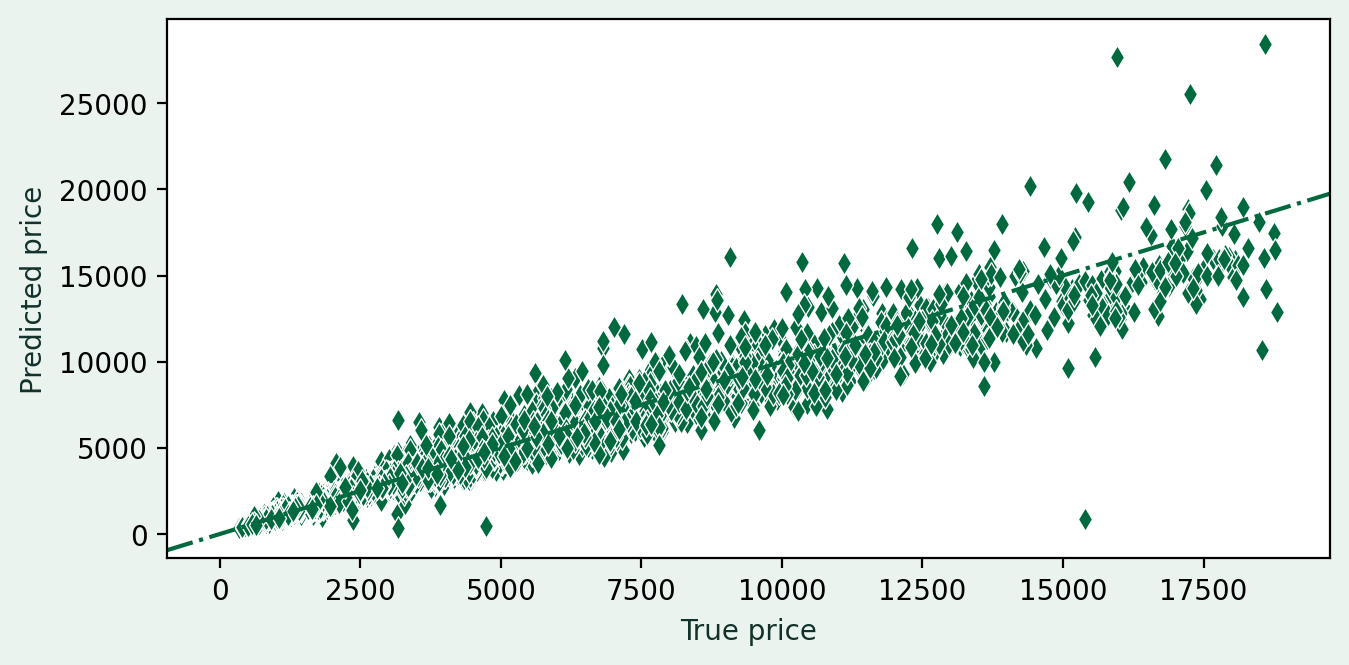

In [25]:
sns.scatterplot(x=y_test, y=y_predict, marker='d')
plt.xlabel('True price')
plt.ylabel('Predicted price')
plt.axline(xy1=(5, 5), slope=1, linestyle='-.')

,Error [%]
count,5394.000000
mean,0.971893
std,15.107109
min,-94.436434
25%,-9.136342
50%,-0.234390
75%,9.269931
max,108.947858


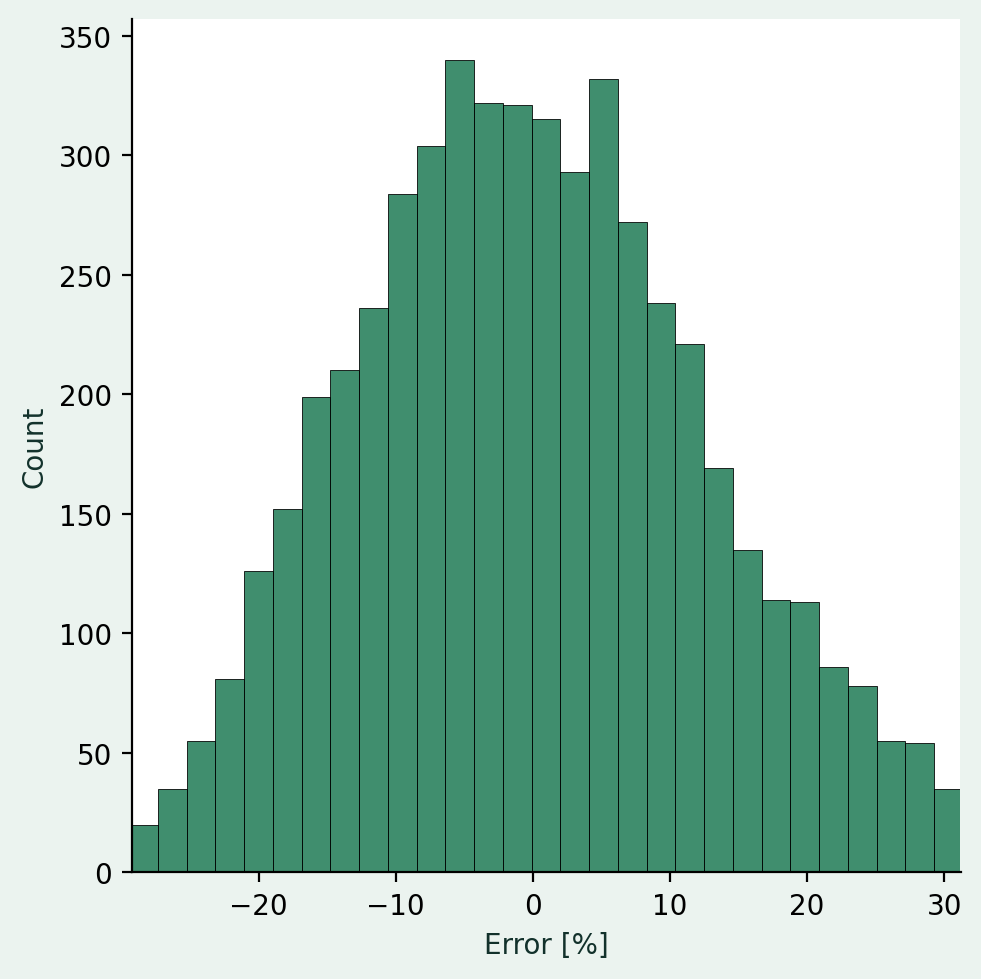

In [26]:
residual = (y_predict - y_test) / y_test * 100
residual.name = 'Error [%]'
sns.displot(residual)
plt.xlim(residual.mean() - 2 * residual.std(), residual.mean() + 2 * residual.std());
pd.DataFrame(residual).describe()